# Texas Hospital Discharge - EDA

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns
sns.set_style("darkgrid")

from IPython.display import display, Markdown
pd.set_option('display.max_columns', None)  

import glob, os

HYPER_TUNING = False
DEBUG = False
SEED = 42

In [5]:
%load_ext autoreload
%autoreload 2

import my_lib

In [6]:
df_patients = pd.read_csv("data/df_train_sample_01_of_20.csv", dtype=str)
df_patients.shape

(49984, 195)

In [7]:
df_facility = pd.read_csv("data/facility.csv", dtype = str)
df_facility.shape

(606, 10)

In [8]:
df = pd.merge(df_patients, df_facility, on="THCIC_ID", how="left")
df.shape

(49984, 204)

In [9]:
df["FAC_UNKNOWN"] = df.FAC_OTHER_LTC_IND.isnull().astype(int)

In [10]:
for c in df.columns:
    if c [:3]=="FAC":
        df[c].fillna(0, inplace=True)

## 1. Encode Target

In [11]:
from sklearn.preprocessing import LabelEncoder
if df['TARGET'].dtype!=int:
    le_target = LabelEncoder()
    df['TARGET']= le_target.fit_transform(df['TARGET'])
else:
    pass

target_labels = {c:le_target.inverse_transform([c])[0] for c in [0,1,2]}
print(target_labels)

df.ADMIT_WEEKDAY.head

{0: 'long', 1: 'medium', 2: 'short'}


<bound method NDFrame.head of 0        4
1        1
2        2
3        1
4        7
        ..
49979    4
49980    5
49981    2
49982    4
49983    1
Name: ADMIT_WEEKDAY, Length: 49984, dtype: object>

## 1.1 Applying Cleaned Cat. Features

In [12]:
my_lib.clean_categories(df)

Feature TYPE_OF_ADMISSION -> ['1' '3' '2' '4' '5' '9']
Feature SOURCE_OF_ADMISSION -> ['1' '4' '5' '2' 'D' '6' '9' '8' '0']
Feature PAT_STATE -> ['TX' 'ZZ' 'XX']
Feature SEX_CODE -> ['U' 'F' 'M']
Feature RACE -> ['5' '4' '3' '2' '1']
Feature ETHNICITY -> ['1' '2' '3']


## 1.2 Feature Engineering

In [13]:
def feature_engineering(df):
    
    feature = "ADMITTING_DIAGNOSIS_UNCHANGED"
    df[feature] = (df.ADMITTING_DIAGNOSIS==df.PRINC_DIAG_CODE) & (df.POA_PRINC_DIAG_CODE=="Y")
    
    feature = "ADMITTING_DIAGNOSIS_CHANGED"
    df[feature] = (df.ADMITTING_DIAGNOSIS!=df.PRINC_DIAG_CODE) & (df.POA_PRINC_DIAG_CODE=="Y")
    
    # admitted via type 'urgent' or 'trauma center' should result in longer stays
    feature = "SERIOUS_ADMISSION"
    df[feature] = (df.TYPE_OF_ADMISSION=="2") | (df.TYPE_OF_ADMISSION=="5")
    
    # admitted via type 'newborn' should result in shorter stays
    feature = "MINOR_ADMISSION"
    df[feature] = (df.TYPE_OF_ADMISSION=="4")
    
    # admitted on the weekend
    feature = "WEEKEND_ADMISSION"
    df[feature] = (df.ADMIT_WEEKDAY=="6") | (df.ADMIT_WEEKDAY=="7")
    
    # admitted during the week
    feature = "WEEK_ADMISSION"
    df[feature] = (df.ADMIT_WEEKDAY!="6") & (df.ADMIT_WEEKDAY!="7")
    
    
feature_engineering(df)

## 1.3 Test-Train Split

In [14]:
from sklearn.model_selection import train_test_split

target = "TARGET"
X = df.drop(target, axis=1)
y = df[target]
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=SEED)

## 1.4 Encoding of Categorical Features

### 1.4.1 Label Binarizer

In [15]:
from sklearn.preprocessing import LabelBinarizer

def encode_features(df_X_train, df_X_test, cat_LabelBinarize=[], bool_features=[], debug=False):
    
    # create dataframes to populate
    df_X_train_model = df_X_train.loc[:, []]
    df_X_test_model = df_X_test.loc[:, []]
    
    # encoding features using LabelBinarizer
    for feature in cat_LabelBinarize:
    
        if debug: print(feature)
            
        # fit and transform on train -> fit decides what label goes to each category
        lb = LabelBinarizer()
        lb_results = lb.fit_transform(df_X_train[feature].astype("str"))
        names= [feature+"_"+l for l in lb.classes_]
        
        if debug: print("\t", names)
            
        for k, name in enumerate(names):
            df_X_train_model[name] = lb_results[:, k]

        # transform on test -> this transform uses the fit already stored
        lb_results = lb.transform(df_X_test[feature].astype("str"))
        names= [feature+"_"+l for l in lb.classes_]
        
        for k, name in enumerate(names):
            df_X_test_model[name] = lb_results[:, k]
        
    for feature in bool_features:
        df_X_train_model[feature] = df_X_train[feature].astype(int)
        df_X_test_model[feature] = df_X_test[feature].astype(int)
    
    return df_X_train_model, df_X_test_model

cat_features = ["TYPE_OF_ADMISSION","SOURCE_OF_ADMISSION","PAT_STATE", "SEX_CODE", "RACE", "ETHNICITY", "ADMIT_WEEKDAY", "PAT_AGE", "POA_PROVIDER_INDICATOR"]
bool_features = ["ADMITTING_DIAGNOSIS_UNCHANGED", "ADMITTING_DIAGNOSIS_CHANGED", "SERIOUS_ADMISSION", "MINOR_ADMISSION", "WEEKEND_ADMISSION", "WEEK_ADMISSION"] + [c for c in df.columns if c[:3]=="FAC"]

df_X_train_model, df_X_test_model = encode_features(df_X_train, df_X_test, cat_LabelBinarize=cat_features, bool_features=bool_features)

In [16]:
df_X_train_model.columns

Index(['TYPE_OF_ADMISSION_1', 'TYPE_OF_ADMISSION_2', 'TYPE_OF_ADMISSION_3',
       'TYPE_OF_ADMISSION_4', 'TYPE_OF_ADMISSION_5', 'TYPE_OF_ADMISSION_9',
       'SOURCE_OF_ADMISSION_1', 'SOURCE_OF_ADMISSION_2',
       'SOURCE_OF_ADMISSION_4', 'SOURCE_OF_ADMISSION_5',
       'SOURCE_OF_ADMISSION_6', 'SOURCE_OF_ADMISSION_8',
       'SOURCE_OF_ADMISSION_9', 'SOURCE_OF_ADMISSION_D', 'PAT_STATE_TX',
       'PAT_STATE_XX', 'PAT_STATE_ZZ', 'SEX_CODE_F', 'SEX_CODE_M',
       'SEX_CODE_U', 'RACE_1', 'RACE_2', 'RACE_3', 'RACE_4', 'RACE_5',
       'ETHNICITY_1', 'ETHNICITY_2', 'ETHNICITY_3', 'ADMIT_WEEKDAY_1',
       'ADMIT_WEEKDAY_2', 'ADMIT_WEEKDAY_3', 'ADMIT_WEEKDAY_4',
       'ADMIT_WEEKDAY_5', 'ADMIT_WEEKDAY_6', 'ADMIT_WEEKDAY_7', 'PAT_AGE_0',
       'PAT_AGE_0-17 (HIV & D/A)', 'PAT_AGE_1-9', 'PAT_AGE_10-19',
       'PAT_AGE_18-44 (HIV & D/A)', 'PAT_AGE_20-29', 'PAT_AGE_30-39',
       'PAT_AGE_40-49', 'PAT_AGE_45-64 (HIV & D/A)', 'PAT_AGE_50-59',
       'PAT_AGE_60-69', 'PAT_AGE_65-74 (HIV & D

In [17]:
# df_X_train_model.drop(columns=features, inplace=True)

In [18]:
X_train, y_train = df_X_train_model.values, df_y_train.values
X_test, y_test = df_X_test_model.values, df_y_test.values

In [19]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier

base_clf = SGDClassifier(loss="log", eta0=10, penalty="l1", learning_rate="adaptive", class_weight="balanced")

classifiers = {
    "LogisticRegression": LogisticRegression(C=0.1, penalty='l1', solver='liblinear'),
    "ExtraTreeClassifierBase": ExtraTreesClassifier(),
    "ExtraTreeClassifierV1": ExtraTreesClassifier(bootstrap=False, criterion='gini', max_depth=8, max_features='log2', min_samples_split=2, n_estimators=200),
    "ExtraTreeClassifierV2": ExtraTreesClassifier(bootstrap=False, criterion='entropy', max_depth=8, max_features='auto', min_samples_split=5, n_estimators=500),
    "BaggingClassifier": BaggingClassifier(base_estimator=base_clf)
}

## 1.5 Model Training

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer

metric = 'recall_macro'
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    training_score = cross_val_score(clf, X_train, y_train, cv=10, n_jobs=-1,
        scoring=metric)
    
    print("%30s has a training score (%s) of %.2f%% " % (name, metric, 100*training_score.mean()))

            LogisticRegression has a training score (recall_macro) of 49.30% 
       ExtraTreeClassifierBase has a training score (recall_macro) of 45.34% 
         ExtraTreeClassifierV1 has a training score (recall_macro) of 47.97% 
         ExtraTreeClassifierV2 has a training score (recall_macro) of 48.29% 
             BaggingClassifier has a training score (recall_macro) of 50.09% 


In [21]:
for name in classifiers:
    classifiers[name].fit(X_train, y_train)

### 1.5.1 Feature Importance

In [22]:
# ExtraTreeClassifierV1 & ExtraTreeClassifierV2 are causing the diagram issue

model = "ExtraTreeClassifierBase"
clf = classifiers[model]

if model == "ExtraTreeClassifierBase":

    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    
    print("Feature Ranking")
    feature_names = [df_X_train_model.columns[indices[f]] for f in range(importances.shape[0])]
    for f in range(importances.shape[0]):
        print("%2d. feature %2d %20s (%f)" % (f+1, indices[f], feature_names[f], importances[indices[f]]))
        

Feature Ranking
 1. feature 62        FAC_REHAB_IND (0.054432)
 2. feature 67         FAC_PEDS_IND (0.049491)
 3. feature 60     FAC_TEACHING_IND (0.040861)
 4. feature 23               RACE_4 (0.032411)
 5. feature 61        FAC_PSYCH_IND (0.029730)
 6. feature 29      ADMIT_WEEKDAY_2 (0.029399)
 7. feature 28      ADMIT_WEEKDAY_1 (0.029107)
 8. feature 31      ADMIT_WEEKDAY_4 (0.028251)
 9. feature 30      ADMIT_WEEKDAY_3 (0.027736)
10. feature 64          FAC_SNF_IND (0.025381)
11. feature 32      ADMIT_WEEKDAY_5 (0.024324)
12. feature 55 ADMITTING_DIAGNOSIS_CHANGED (0.023600)
13. feature 54 ADMITTING_DIAGNOSIS_UNCHANGED (0.023054)
14. feature 24               RACE_5 (0.022786)
15. feature 22               RACE_3 (0.022253)
16. feature 51 POA_PROVIDER_INDICATOR_M (0.021228)
17. feature 17           SEX_CODE_F (0.021076)
18. feature 52 POA_PROVIDER_INDICATOR_R (0.020619)
19. feature 18           SEX_CODE_M (0.020494)
20. feature 63   FAC_ACUTE_CARE_IND (0.018513)
21. feature 53 POA_P

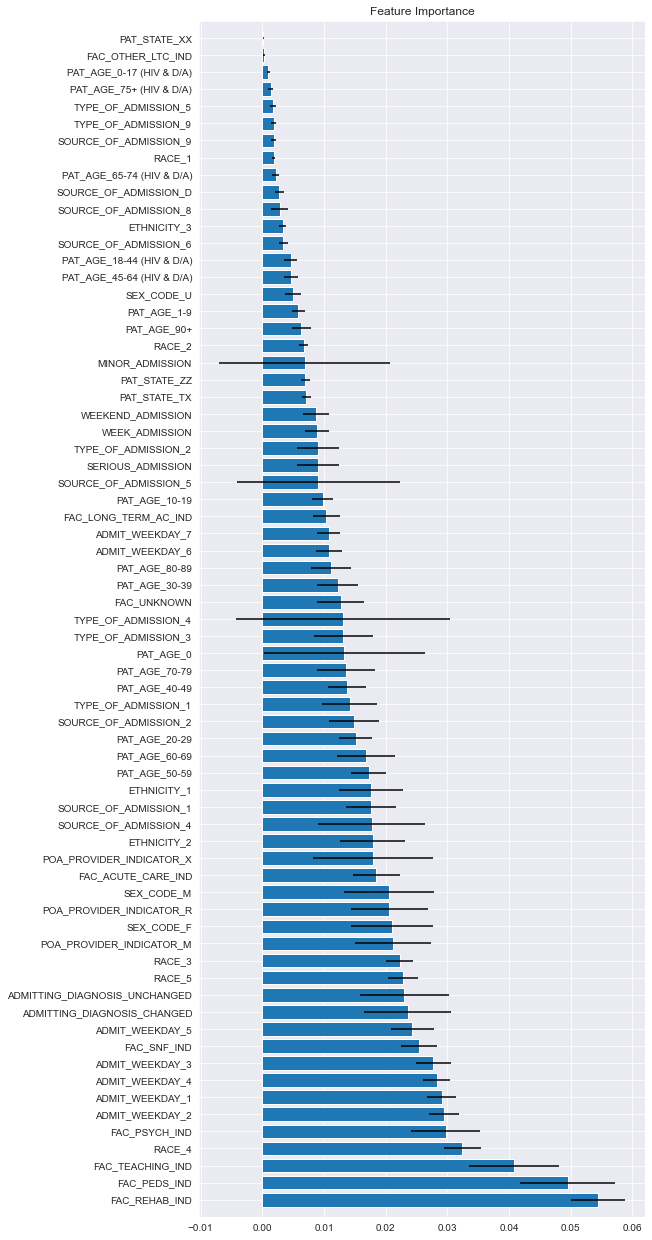

In [23]:
plt.figure(figsize=(8,22))
plt.title("Feature Importance")
plt.barh(range(importances.shape[0]), importances[indices], xerr=std[indices], align='center')
plt.yticks(range(importances.shape[0]), feature_names)
plt.ylim([-1, importances.shape[0]])
plt.show()

### 1.5.1.1 Delete Unimportant Features

In [97]:
# unimportant_features = ['PAT_STATE_XX','TYPE_OF_ADMISSION_9','RACE_1','SOURCE_OF_ADMISSION_9','TYPE_OF_ADMISSION_5','ADMIT_WEEKDAY_4']
# df_X_train_new_model = df_X_train_model
# df_X_train_new_model.drop(columns=unimportant_features, inplace=True)

# X_train, y_train = df_X_train_model.values, df_y_train.values
# X_test, y_test = df_X_train_model.values, df_y_test.values

### 1.5.1.2 Retrain

In [98]:
# metric = 'recall_macro'
# for name, clf in classifiers.items():
#     clf.fit(X_train, y_train)
#     training_score = cross_val_score(clf, X_train, y_train, cv=10, n_jobs=-1,
#         scoring=metric)
    
#     print("%30s has a training score (%s) of %.2f%% " % (name, metric, 100*training_score.mean()))

           ExtraTreeClassifier has a training score (recall_macro) of 45.35% 


### 1.5.2 Metrics

In [122]:
# pd.crosstab(df_pred.true.map(target_labels), df_pred[model].map(target_labels), rownames=['True'], colnames=['Predicted'])

In [123]:
# from sklearn.metrics import classification_report 
# print(classification_report(df_pred.true, df_pred[model], target_names=le_target.inverse_transform([0,1,2])))

### 1.5.3 Hyper-Parameter Tuning

In [22]:
from sklearn.model_selection import GridSearchCV

param_space = {
    
    "LogisticRegression": {
        "solver":["liblinear"],
        "penalty": ['l1', 'l2'], 
        "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    },
    
    "ExtraTreeClassifier": {
        "n_estimators":[200, 500],
        "max_features":["auto", "sqrt", "log2"],
        "min_samples_split":[2,5,10],
        "max_depth": [4,5,6,7,8],
        "criterion":["gini", "entropy"],
        "bootstrap":[True, False]
    },
    "BaggingClassifier": {
        "max_samples": [0.5, 1.0],
        "max_features": [1, 2, 4],
        "bootstrap": [True, False],
        "bootstrap_features": [True, False]
    }
}
    

best_classifiers = {}

In [23]:
if HYPER_TUNING == True:

    for name, clf in classifiers.items():

        param = param_space[name]
        print("\n\nPerforming GridSearchCV on %s..." % name)
        clf = GridSearchCV(classifiers[name], param, cv=5, scoring=metric )

        clf.fit(X_train, y_train)
        best_classifiers[name] = clf

        score = cross_val_score(clf, X_train, y_train, cv=10)
        print(best_classifiers[name])
        print("%s Cross Validation Score (%s): %.2f%%" % (name, metric, 100*score.mean()))

        print("Best Params: \n")
        print(best_classifiers[name].best_params_)



Performing GridSearchCV on ExtraTreeClassifier...
GridSearchCV(cv=5, error_score=nan,
             estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                            class_weight=None, criterion='gini',
                                            max_depth=None, max_features='auto',
                                            max_leaf_nodes=None,
                                            max_samples=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100, n_jobs=None,
                                            o...dom_state=None,
                                            verbose=0, warm_start

In [114]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score

if HYPER_TUNING == True:

    best_classifier_pred = {}
    for name in classifiers:
        pred = cross_val_predict(best_classifiers[name], X_train, y_train, cv=10)
        best_classifier_pred[name] = pred

    best_classifier_pred['true'] = y_train
    df_best_pred = pd.DataFrame(best_classifier_pred)

## 1.6 Grading

In [66]:
df.to_csv("data/test.csv", index=False)

In [18]:
df_grading = pd.read_csv(f"data/grading.csv", dtype=str)
df_grading.shape

(100000, 193)

In [19]:
df_grading = pd.merge(df_grading, df_facility, on="THCIC_ID", how="left")
df_grading.shape

(100000, 202)

In [20]:
df_grading["FAC_UNKNOWN"] = df_grading.FAC_OTHER_LTC_IND.isnull().astype(int)

for c in df.columns:
    if c [:3]=="FAC":
        df_grading[c].fillna(0, inplace=True)

### 1.6.1. Encoding `df_grading`

In [117]:
my_lib.clean_categories(df_grading)

Feture TYPE_OF_ADMISSION -> ['2' '1' '3' '4' '5' '9']
Feture SOURCE_OF_ADMISSION -> ['1' '2' '5' '6' 'D' '4' '8' '9' '0']
Feture PAT_STATE -> ['TX' 'ZZ' 'XX']
Feture SEX_CODE -> ['F' 'M' 'U']
Feture RACE -> ['4' '5' '3' '2' '1']
Feture ETHNICITY -> ['1' '2' '3']


In [118]:
df_X_train_model, df_X_test_model = encode_features(df_X_train, df_grading, cat_LabelBinarize)

### 1.6.2. Make Predictions

In [119]:
model = "ExtraTreeClassifier"
df_grading['TARGET'] = classifiers[model].fit(df_X_train_model, y_train).predict(df_X_test_model)
df_grading['TARGET'] = df_grading['TARGET'].map(target_labels)

### 1.6.3. Save Predictions

In [120]:
df_grading.loc[:, ["RECORD_ID", "TARGET"]].to_csv("df_grading_pred.csv", index=False)

### 1.6.4. Generate Archive

In [121]:
my_lib.make_assignment()

Creating archive: my_assignment.zip
	01-Import.ipynb - OK
	02-EDA.ipynb - OK
	03-Model.ipynb - OK
	my_lib.py - OK
	df_grading_pred.csv - OK
